In [1]:
import os
# Ignore TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

from tensorflow.keras.datasets import imdb

from deepthink.layers import EmbeddingLayer, GlobalAveragePooling1D, Dense
from deepthink.model import Model
from deepthink.optimizers import Adam
from deepthink.loss import BinaryCrossEntropy
from deepthink.activations import Sigmoid
from deepthink.utils import pad_sequences

# Set default matplotlib style
plt.style.use('ggplot')

## IMDB Sentiment Analysis

The purpose of this notebook is to demonstrate text-classification using [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). This example is inspired by [this](https://www.tensorflow.org/tutorials/keras/text_classification) TensorFlow tutorial.

#### IMDB Dataset

The dataset used is the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/), which consists of 50,000 movie reviews from [imdb.com](https://www.imdb.com/) split into 25,000 for training and 25,000 for testing. Each review is classed as positive or negative (1 or 0 respectively) and the goal is to predict this from the review text. Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).

In [4]:
# Define the parameters
max_features = 10000  # Maximum vocab size
seq_len = 200  # Maximum length of each review
embedding_dim = 16
batch_size = 32
epochs = 10
learning_rate = 0.001

In [5]:
# Load the data
(train_text, train_labels), (X_test, y_test) = imdb.load_data(num_words=max_features)

# Reshape labels to column vector
train_labels = train_labels.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(train_text.shape, train_labels.shape)
print(X_test.shape, y_test.shape)

(25000,) (25000, 1)
(25000,) (25000, 1)


In [6]:
# View a sample review
sample = np.random.choice(train_text)
# Get the word index for each word in the review
word_to_idx = imdb.get_word_index()
# Create a reverse word index
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Convert the review to text
review = ' '.join([idx_to_word.get(idx - 3, '?') for idx in sample])
print(review)

? i could not even bring myself to watch this movie to the end i cannot comment on the story as i did not watch the whole film and the reason i couldn't watch it was because of the ? firstly for the most part they just looked stiff and i'm sure their scripts were in their hands just out of frame but that's a minor issue the main issue i have with the actors isn't really their fault it's whoever cast this film come on this movie came out in 2003 i thought that casting people in their late ? to play teenagers went out of fashion with new wave i cannot watch a movie where one of the first lines from a grown man older than myself is i'm 17 how can anyone take that seriously don't fall victim to this movie go out for a walk for 90 minutes and you'll get far more than this movie could ever give


In [7]:
# Pad the sequences
train_text = pad_sequences(train_text, seq_len)
X_test = pad_sequences(X_test, seq_len)

In [8]:
# Shuffle the data and split into training and validation sets
# (20k training, 5k validation as per the TensorFlow tutorial)
train_size = 20000
random_perm = np.random.permutation(train_text.shape[0])
train_text = train_text[random_perm]
train_labels = train_labels[random_perm]

X_train = train_text[:train_size]
y_train = train_labels[:train_size]
X_valid = train_text[train_size:]
y_valid = train_labels[train_size:]

In [9]:
# Define the model
opt = Adam(learning_rate=learning_rate)
model = Model(opt, cost=BinaryCrossEntropy(),
              batch_size=batch_size,
              metrics=['accuracy'])

model.add_layer(EmbeddingLayer(max_features, embedding_dim,
                               input_shape=(batch_size, seq_len)))
model.add_layer(GlobalAveragePooling1D())
model.add_layer(Dense(1))
model.add_layer(Sigmoid())

model.initialize()

In [10]:
model.summary()

Model summary:
_________________________________________________________________
Layer Type                 Output Shape                   Param #
Embedding Layer           (None, 16, 200)                  160000
GlobalAveragePooling      (None, 16)                            0
Dense(1)                  (None, 1)                            17
Sigmoid Activation        (None, 1)                             0
Total params: 160017


In [11]:
history = model.train((X_train, y_train),
                      validation_data=(X_valid, y_valid),
                      epochs=epochs)

100%|██████████| 625/625 [00:08<00:00, 77.96it/s]


Epoch: 1/10, elapsed-time: 8.26s - loss: 0.5801 - accuracy: 0.7869 - val_loss: 0.5858 - val_accuracy: 0.7754 - 


100%|██████████| 625/625 [00:07<00:00, 78.28it/s]


Epoch: 2/10, elapsed-time: 16.30s - loss: 0.5123 - accuracy: 0.8125 - val_loss: 0.4627 - val_accuracy: 0.8261 - 


100%|██████████| 625/625 [00:08<00:00, 76.22it/s]


Epoch: 3/10, elapsed-time: 24.57s - loss: 0.4077 - accuracy: 0.8557 - val_loss: 0.3941 - val_accuracy: 0.8452 - 


100%|██████████| 625/625 [00:08<00:00, 77.70it/s]


Epoch: 4/10, elapsed-time: 32.68s - loss: 0.3471 - accuracy: 0.8725 - val_loss: 0.3601 - val_accuracy: 0.8556 - 


100%|██████████| 625/625 [00:08<00:00, 78.11it/s]


Epoch: 5/10, elapsed-time: 40.74s - loss: 0.3085 - accuracy: 0.8867 - val_loss: 0.3356 - val_accuracy: 0.8654 - 


100%|██████████| 625/625 [00:08<00:00, 75.83it/s]


Epoch: 6/10, elapsed-time: 49.04s - loss: 0.2801 - accuracy: 0.8961 - val_loss: 0.3225 - val_accuracy: 0.8686 - 


100%|██████████| 625/625 [00:08<00:00, 76.19it/s]


Epoch: 7/10, elapsed-time: 57.30s - loss: 0.2576 - accuracy: 0.9070 - val_loss: 0.3130 - val_accuracy: 0.8740 - 


100%|██████████| 625/625 [00:08<00:00, 75.95it/s]


Epoch: 8/10, elapsed-time: 65.58s - loss: 0.2392 - accuracy: 0.9124 - val_loss: 0.3077 - val_accuracy: 0.8754 - 


100%|██████████| 625/625 [00:08<00:00, 77.55it/s]


Epoch: 9/10, elapsed-time: 73.70s - loss: 0.2228 - accuracy: 0.9193 - val_loss: 0.3049 - val_accuracy: 0.8760 - 


100%|██████████| 625/625 [00:08<00:00, 75.05it/s]

Epoch: 10/10, elapsed-time: 82.08s - loss: 0.2090 - accuracy: 0.9228 - val_loss: 0.3036 - val_accuracy: 0.8780 - 


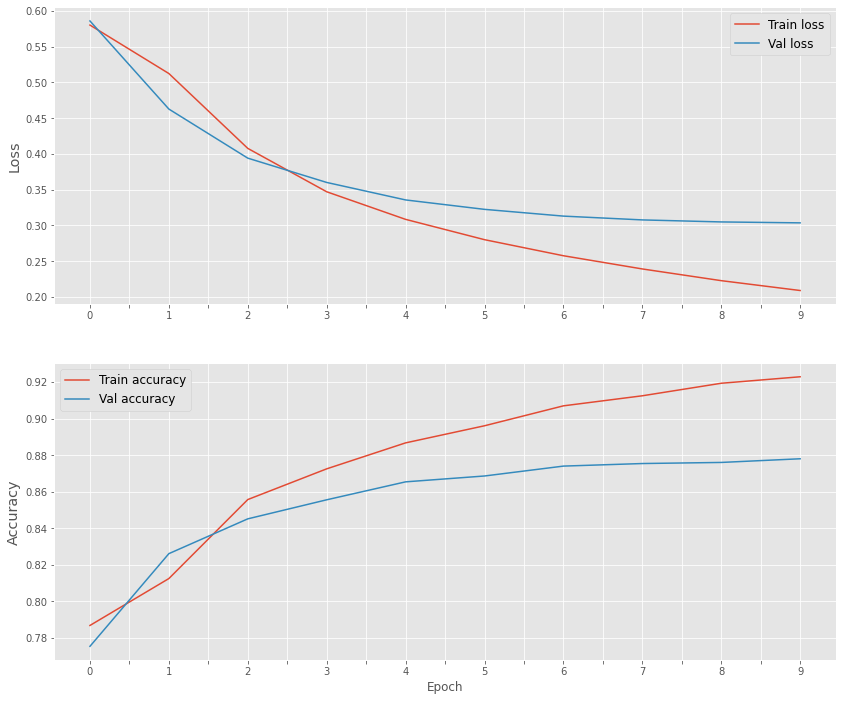

In [12]:
# Plot training history

history.plot_history()

In [13]:
# Evaluate on test data
test_preds = model.get_predictions(X_test)
test_labels = y_test[:test_preds.shape[0]]
test_loss = BinaryCrossEntropy()(test_labels, test_preds)
binary_preds = np.round(test_preds)
test_acc = np.mean(binary_preds == test_labels)


print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.2%}')


Test Loss: 0.3231
Test Accuracy: 86.42%
